In [1]:
# https://keras.io/
!pip install -q keras
import keras 

Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as k
import numpy as np
from matplotlib import pyplot
from keras.callbacks import LearningRateScheduler

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
# Hyperparameters
batch_size = 64
num_classes =  10
epochs = 200
l = 36
num_filter = 12
compression = 0.5
dropout_rate = 0


In [5]:
# ak - custimized code block 0

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
# ak - custimized code block 1 
# code help from https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

# train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
# test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))
# y_train = np.array(y_train[train_picks]==5,dtype=int)
# y_test = np.array(y_test[test_picks]==5,dtype=int)
# x_train = x_train[train_picks]
# x_test = x_test[test_picks]

In [7]:
# ak - customized code block 2

# print(x_train.shape)
# print(x_test.shape)

# print(y_train.shape)

# from matplotlib import pyplot as plt
# %matplotlib inline
# plt.imshow(x_train[0])

# img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')



In [8]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 63s 0us/step


(50000, 32, 32, 3)
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


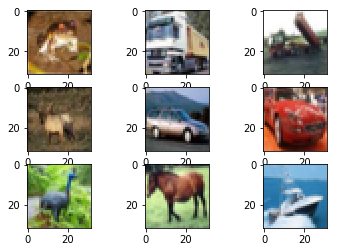

In [9]:
print(x_train.shape)
print(y_train.shape)
print(y_train[0])

from matplotlib import pyplot as plt
%matplotlib inline
# plt.imshow(x_train[30])


#Look at the first 9 images from the dataset
images = range(0,9)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    
#Show the plot
plt.show()

In [10]:
# ak - customized code block 3
def lr_schedule(epoch):
    lrate = 0.1
    if epoch > 100:
        lrate = 0.01
    elif epoch > 150:
        lrate = 0.001       
    return lrate

datagen = ImageDataGenerator(
         horizontal_flip=True
         ,fill_mode='nearest'
          )

# parameters tried 
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
# datagen = ImageDataGenerator(contrast_stretching=True, adaptive_equalization=True, histogram_equalization=True)


# fit parameters from data
datagen.fit(x_train)

# for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
#     # Show 9 images
#     for i in range(0, 9):
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(X_batch[i].reshape(img_height, img_width, 3))
#     # show the plot
#     pyplot.show()
#     break
    
# print(X_batch.shape)

In [11]:
# Dense Block
def add_denseblock(input, num_filter , dropout_rate):
  
    #print('Dense Block')
    
    global compression
    temp = input
    
    #print('temp')
    #print(temp.shape)
    
    for _ in range(l):
      
        #print(_)
        
        BatchNorm = BatchNormalization()(temp)
        
        #print('BatchNorm')
        #print(BatchNorm.shape)
        
        relu = Activation('relu')(BatchNorm)
        
        #print('relu')
        #print(relu.shape)
        
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        
        #print('Conv2D_3_3')
        #print(Conv2D_3_3.shape)
        
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
          
          #print('dropout')
          #print(Conv2D_3_3.shape)
          
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        #print('concat')
        #print(concat.shape)
        
        temp = concat
        
    return temp

In [12]:
def add_transition(input, num_filter , dropout_rate ):
    global compression
    
    #print('Transition')
    
    BatchNorm = BatchNormalization()(input)
    
    #print('BatchNorm')
    #print(BatchNorm.shape) 
    
    relu = Activation('relu')(BatchNorm)

    #print('relu')
    #print(relu.shape)
    
    
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    
    #print('Conv2D_BottleNeck')
    #print(Conv2D_BottleNeck.shape)
    
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
      
      #print('dropout_rate')
      #print(Conv2D_BottleNeck.shape)
      
      
      
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
  
    #print('avg')
    #print(avg.shape)
    
    
    return avg

In [13]:
def output_layer(input):
    global compression
    
    #print('Output Layer')
    
    BatchNorm = BatchNormalization()(input)
    
    #print('BatchNorm')
    #print(BatchNorm.shape)   
    
    relu = Activation('relu')(BatchNorm)
    
    #print('relu')
    #print(relu.shape)
    
    
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    
    #print('AvgPooling')
    #print(AvgPooling.shape)
    
    flat = Flatten()(AvgPooling)
    
    #print('flat')
    #print(flat)  
    
    output = Dense(num_classes, activation='softmax')(flat)
   
    #print('output')
    #print(output.shape)
    
    
    return output

In [14]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
# determine Loss function and Optimizer
sgd = SGD(decay=10e-4,momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [17]:
# ak - customized code block 4

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0]/batch_size,
                        epochs=200,
                        validation_data=(x_test, y_test),
                        callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/200
782/781 [==============================] - 172s 220ms/step - loss: 1.7887 - acc: 0.3552 - val_loss: 2.0931 - val_acc: 0.3076
Epoch 2/200
782/781 [==============================] - 144s 185ms/step - loss: 1.3402 - acc: 0.5137 - val_loss: 1.7029 - val_acc: 0.4496
Epoch 3/200
782/781 [==============================] - 144s 184ms/step - loss: 1.0976 - acc: 0.6042 - val_loss: 1.5096 - val_acc: 0.5076
Epoch 4/200
782/781 [==============================] - 144s 185ms/step - loss: 0.9359 - acc: 0.6674 - val_loss: 1.5878 - val_acc: 0.4951
Epoch 5/200
782/781 [==============================] - 143s 183ms/step - loss: 0.8172 - acc: 0.7118 - val_loss: 1.3203 - val_acc: 0.5805
Epoch 6/200
782/781 [==============================] - 144s 184ms/step - loss: 0.7360 - acc: 0.7416 - val_loss: 1.7410 - val_acc: 0.5088
Epoch 7/200
782/781 [==============================] - 143s 183ms/step - loss: 0.6713 - acc: 0.7636 - val_loss: 0.8237 - val_acc: 0.7156
Epoch 8/200
782/781 [====================

782/781 [==============================] - 146s 187ms/step - loss: 0.0575 - acc: 0.9793 - val_loss: 0.8573 - val_acc: 0.8273
Epoch 61/200
782/781 [==============================] - 145s 185ms/step - loss: 0.0479 - acc: 0.9835 - val_loss: 0.8423 - val_acc: 0.8316
Epoch 62/200
782/781 [==============================] - 145s 186ms/step - loss: 0.0460 - acc: 0.9839 - val_loss: 0.8517 - val_acc: 0.8292
Epoch 63/200
782/781 [==============================] - 143s 183ms/step - loss: 0.0434 - acc: 0.9854 - val_loss: 0.9076 - val_acc: 0.8290
Epoch 64/200
782/781 [==============================] - 145s 185ms/step - loss: 0.0452 - acc: 0.9837 - val_loss: 1.4395 - val_acc: 0.7405
Epoch 65/200
782/781 [==============================] - 144s 184ms/step - loss: 0.0534 - acc: 0.9812 - val_loss: 0.9808 - val_acc: 0.8144
Epoch 66/200
782/781 [==============================] - 145s 185ms/step - loss: 0.0454 - acc: 0.9842 - val_loss: 0.7797 - val_acc: 0.8435
Epoch 67/200
782/781 [=========================

782/781 [==============================] - 142s 182ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.8494 - val_acc: 0.8590
Epoch 120/200
782/781 [==============================] - 144s 184ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.8505 - val_acc: 0.8582
Epoch 121/200
782/781 [==============================] - 144s 184ms/step - loss: 9.9773e-04 - acc: 1.0000 - val_loss: 0.8501 - val_acc: 0.8586
Epoch 122/200
782/781 [==============================] - 145s 185ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.8531 - val_acc: 0.8578
Epoch 123/200
782/781 [==============================] - 144s 184ms/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.8499 - val_acc: 0.8579
Epoch 124/200
782/781 [==============================] - 144s 184ms/step - loss: 9.2024e-04 - acc: 0.9999 - val_loss: 0.8533 - val_acc: 0.8580
Epoch 125/200
782/781 [==============================] - 144s 184ms/step - loss: 8.7671e-04 - acc: 1.0000 - val_loss: 0.8520 - val_acc: 0.8583
Epoch 126/200
782/781 [======

782/781 [==============================] - 145s 186ms/step - loss: 4.0945e-04 - acc: 1.0000 - val_loss: 0.8792 - val_acc: 0.8596
Epoch 177/200
782/781 [==============================] - 145s 185ms/step - loss: 4.1403e-04 - acc: 1.0000 - val_loss: 0.8812 - val_acc: 0.8586
Epoch 178/200
782/781 [==============================] - 146s 186ms/step - loss: 4.2709e-04 - acc: 1.0000 - val_loss: 0.8812 - val_acc: 0.8587
Epoch 179/200
782/781 [==============================] - 144s 184ms/step - loss: 4.5525e-04 - acc: 1.0000 - val_loss: 0.8822 - val_acc: 0.8584
Epoch 180/200
782/781 [==============================] - 143s 183ms/step - loss: 4.4397e-04 - acc: 1.0000 - val_loss: 0.8819 - val_acc: 0.8589
Epoch 181/200
782/781 [==============================] - 142s 182ms/step - loss: 4.1410e-04 - acc: 1.0000 - val_loss: 0.8829 - val_acc: 0.8589
Epoch 182/200
782/781 [==============================] - 143s 183ms/step - loss: 3.9923e-04 - acc: 1.0000 - val_loss: 0.8831 - val_acc: 0.8589
Epoch 183/200

In [0]:
# model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, y_test))

In [18]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 9s 860us/step
Test loss: 0.8877773536279797
Test accuracy: 0.86


In [19]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_epoch200.h5")
print("Saved model to disk")

Saved model to disk
